In [3]:
import sys


import numpy as np
import h5py
import Analysis
from copy import deepcopy

def AddFitMetadata(path, h5_path, A, extra_dict=None):
        h5 = h5py.File(path)
        
        try: 
            h5.create_group(h5_path)
        except:
            del h5[h5_path]
            h5.create_group(h5_path)
            

        fa = h5[h5_path].attrs
        fit = A.SaveFit()

        for key, val in fit.items():
            if key not in ['Data', 'energies', 'loglike', 'PSC']:
                fa.create('flux_'+key,val['flux'])
                fa.create('fluxunc_'+key,val['fluxunc'])        

        fa.create('loglike_total',np.sum(A.loglike))
        fa.create('loglike',A.loglike)
        fa.create('energies',A.central_energies)
        fa.create('bins', A.bin_edges)
        fa.create('irf', A.irf)
        fa.create('evclass', A.evclass)
        fa.create('convtype', A.convtype)
        fa.create('phfile', A.phfile)
        fa.create('tag', A.tag)

        if extra_dict is not None:
            for key, val in extra_dict.items():
                if key == 'residual':
                    try:
                        del h5[h5_path+'/residual']
                    except: 
                        pass

                    h5.create_dataset(h5_path+'/residual', data=val, dtype='float32')
                    print 'Saving new residual... Shape = ', val.shape
                else:
                    fa.create(key, val)
        h5.close()

def LoadModel(basedir, galprop_tag):
    # Load various diffuse models and run fits.
    print 'Running Analysis for model', galprop_tag
    
    
    A = Analysis.Analysis(tag='P8R2_CLEAN_V6_calore', basepath='/data/GCE_sys/')
    #A = Analysis.Analysis(tag='P8R2_CLEAN_V6_calore', basepath='/data/GCE_sys/')
    
    
    A.GenSquareMask(l_range=[-20,20], b_range=[-20,20], plane_mask=2.)
    A.BinPhotons(infile='binned_photons_'+A.tag+'.npy')
    # Load 2FGL 
    A.AddPointSourceTemplate(fixNorm=True,pscmap='PSC_' + A.tag + '_fgl3_with_ext.npy')
    A.CalculatePixelWeights(diffuse_model='fermi_diffuse_'+A.tag+'.npy',psc_model='PSC_' + A.tag + '_fgl3_with_ext.npy',
                        alpha_psc=5., f_psc=0.1)
    A.AddIsotropicTemplate(fixNorm=False, fixSpectrum=False) # External chi^2 used to fix normalization within uncertainties
    
    A.AddFermiBubbleTemplate(template_file='./bubble_templates_diskcut30.0.fits', 
                         spec_file='./reduced_bubble_spec_apj_793_64.dat', fixSpectrum=False, fixNorm=False)
    
    
    A.AddHDF5Template(hdf5file=basedir +'/'+ galprop_tag+'.hdf5',verbosity=1, multiplier=2., bremsfrac=1.25, 
                  E_subsample=2, fixSpectrum=False, separate_ics=False)
    return A



In [20]:
A = LoadModel('/data/GCE_sys/new','mod_s_42_XCO_P8')
A2 = LoadModel('/data/GCE_sys/new','mod_s_42_XCO_P8')

#/data/GCE_sys/new/mod_s_44_XCO_P8.hdf5

Running Analysis for model mod_s_42_XCO_P8
Loading HDF5 file
Integrating and Resampling ics templates...
Integrating and Resampling pi0 templates...
Integrating and Resampling brem templates...
Running Analysis for model mod_s_42_XCO_P8
Loading HDF5 file
Integrating and Resampling ics templates...
Integrating and Resampling pi0 templates...
Integrating and Resampling brem templates...


In [21]:
A.AddDMTemplate(profile='NFW', limits=[None,None], decay=False, gamma=1.25, 
               r_s=20.0, axesratio=1., offset=(0., 0.), spec_file=None,)

A2.AddDMTemplate(profile='NFW', limits=[None,None], decay=False, gamma=1.25, 
               r_s=20.0, axesratio=1., offset=(0., 0.), spec_file=None,)


# A2.AddDMTemplate(profile='NFW', limits=[None,None], decay=False, gamma=.4, 
#                r_s=20.0, axesratio=2.6, offset=(0., 0.), spec_file=None,)



#A.AddParabolicTemplate(0.09,spec_file='./reduced_bubble_spec_apj_793_64.dat', fixSpectrum=False, fixNorm=False)
A2.AddParabolicTemplate(0.09,spec_file='./reduced_bubble_spec_apj_793_64.dat', fixSpectrum=False, fixNorm=False)


In [22]:
A.ResetFit()    

A.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=False, statistic='Poisson')[0]
A2.RunLikelihood(print_level=1, tol=2e2, precision=None, minos=False)[0]


Masking completed in 7.5894e-01 s
Write likelihood tempfile to  /tmp/tmpVwJEcr
Code generation completed in 1.2121e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -602607.484654 
 TOTAL NCALL = 158 
 NCALLS = 158 
 
 
 EDM = 0.000298112088995 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_0,1.001326e+00,9.353055e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_0,9.896031e-01,6.860954e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_0,1.921153e+00,1.149072e-01,0.000000e+00,0.000000e+00,,,
5,ICS_0,6.882930e-01,1.966082e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_0,6.946197e-01,1.606205e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.89e-01 s
Masking completed in 7.7042e-01 s
Write likelihood tempfile to  /tmp/tmpke6Dyr
Code generation completed in 1.1971e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -476323.394004 
 TOTAL NCALL = 149 
 NCALLS = 149 
 
 
 EDM = 0.000143126629254 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_1,9.996291e-01,1.074642e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_1,1.030524e+00,7.420035e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_1,1.772367e+00,1.216071e-01,0.000000e+00,0.000000e+00,,,
5,ICS_1,7.016304e-01,2.063270e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_1,6.574884e-01,1.538742e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.79e-01 s
Masking completed in 8.6789e-01 s
Write likelihood tempfile to  /tmp/tmp1SW4Op
Code generation completed in 1.2281e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -373995.882937 
 TOTAL NCALL = 157 
 NCALLS = 157 
 
 
 EDM = 1.36578574878e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_2,9.995484e-01,1.153916e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_2,1.062127e+00,8.146344e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_2,1.465254e+00,1.268415e-01,0.000000e+00,0.000000e+00,,,
5,ICS_2,7.649375e-01,2.225245e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_2,8.412818e-01,1.505247e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.89e-01 s
Masking completed in 9.1022e-01 s
Write likelihood tempfile to  /tmp/tmp9ShrbI
Code generation completed in 1.2460e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -286216.638343 
 TOTAL NCALL = 158 
 NCALLS = 158 
 
 
 EDM = 3.77990200199e-07 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_3,1.009595e+00,1.120159e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_3,1.077079e+00,8.817360e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_3,1.352985e+00,1.283969e-01,0.000000e+00,0.000000e+00,,,
5,ICS_3,7.579364e-01,2.330325e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_3,9.415843e-01,1.533051e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.88e-01 s
Masking completed in 9.3747e-01 s
Write likelihood tempfile to  /tmp/tmpaYpRsM
Code generation completed in 3.7112e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -276031.331515 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 0.000725589701845 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_4,9.983555e-01,1.218980e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_4,1.077974e+00,8.898040e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_4,1.250345e+00,1.205108e-01,0.000000e+00,0.000000e+00,,,
5,ICS_4,8.102139e-01,2.282894e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_4,7.368075e-01,1.399162e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.12e-01 s
Masking completed in 1.2942e+00 s
Write likelihood tempfile to  /tmp/tmpMsIhQq
Code generation completed in 1.5590e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -274152.178195 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 0.0016535650498 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_5,9.986723e-01,8.269152e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_5,1.131262e+00,9.044632e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_5,1.164106e+00,1.094961e-01,0.000000e+00,0.000000e+00,,,
5,ICS_5,7.550161e-01,2.261710e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_5,7.511828e-01,1.261380e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.13e-01 s
Masking completed in 1.1605e+00 s
Write likelihood tempfile to  /tmp/tmpsicmui
Code generation completed in 1.4632e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -263602.522728 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 0.00221779276919 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_6,9.990744e-01,9.424202e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_6,1.111425e+00,8.833120e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_6,1.075573e+00,9.789961e-02,0.000000e+00,0.000000e+00,,,
5,ICS_6,7.469985e-01,2.149523e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_6,8.374199e-01,1.173976e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.12e-01 s
Masking completed in 1.1790e+00 s
Write likelihood tempfile to  /tmp/tmpHD5aJg
Code generation completed in 1.4999e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -245141.612016 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 0.001261541695 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_7,9.987345e-01,7.574456e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_7,1.144120e+00,9.121228e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_7,1.090461e+00,9.610346e-02,0.000000e+00,0.000000e+00,,,
5,ICS_7,7.084333e-01,2.201717e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_7,9.817026e-01,1.088926e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.13e-01 s
Masking completed in 1.1503e+00 s
Write likelihood tempfile to  /tmp/tmpFweQbv
Code generation completed in 1.6551e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -230548.732329 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 0.000744670191623 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_8,9.991223e-01,7.768559e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_8,1.104273e+00,9.054004e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_8,9.192462e-01,9.632409e-02,0.000000e+00,0.000000e+00,,,
5,ICS_8,7.743783e-01,2.137235e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_8,9.026371e-01,1.055661e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.13e-01 s
Masking completed in 1.1580e+00 s
Write likelihood tempfile to  /tmp/tmpGZ0NkQ
Code generation completed in 3.4111e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -206775.946034 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 0.000377597221506 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_9,9.993561e-01,7.274035e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_9,1.130871e+00,9.437310e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_9,9.707254e-01,9.682131e-02,0.000000e+00,0.000000e+00,,,
5,ICS_9,7.527138e-01,2.179642e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_9,9.014476e-01,1.068581e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.67e-01 s
Masking completed in 1.0583e+00 s
Write likelihood tempfile to  /tmp/tmpOQ7iSt
Code generation completed in 1.4961e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -188927.566029 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 0.00109016807164 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_10,9.998523e-01,5.628327e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_10,1.119929e+00,9.550836e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_10,1.079505e+00,1.015286e-01,0.000000e+00,0.000000e+00,,,
5,ICS_10,7.100718e-01,2.134629e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_10,8.611631e-01,9.886006e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.64e-01 s
Masking completed in 1.1117e+00 s
Write likelihood tempfile to  /tmp/tmpF7iVmQ
Code generation completed in 3.5641e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -155211.610801 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 0.000609617824775 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_11,1.000123e+00,5.295322e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_11,1.124707e+00,1.012821e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_11,1.078858e+00,1.070403e-01,0.000000e+00,0.000000e+00,,,
5,ICS_11,7.112484e-01,2.193849e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_11,8.727396e-01,9.944678e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.68e-01 s
Masking completed in 1.1164e+00 s
Write likelihood tempfile to  /tmp/tmpKyJVGy
Code generation completed in 3.5689e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -122836.951183 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 0.000662432880028 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_12,9.997493e-01,5.451042e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_12,1.150425e+00,1.086959e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_12,1.036552e+00,1.147353e-01,0.000000e+00,0.000000e+00,,,
5,ICS_12,6.578601e-01,2.245927e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_12,1.091984e+00,9.181710e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.73e-01 s
Masking completed in 1.1462e+00 s
Write likelihood tempfile to  /tmp/tmpE79C9O
Code generation completed in 7.6940e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -89095.2064432 
 TOTAL NCALL = 124 
 NCALLS = 124 
 
 
 EDM = 0.00119571475548 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_13,1.000639e+00,4.887823e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_13,1.096981e+00,1.150817e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_13,8.961694e-01,1.207740e-01,0.000000e+00,0.000000e+00,,,
5,ICS_13,6.860035e-01,2.262790e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_13,9.609380e-01,8.859618e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.60e-01 s
Masking completed in 1.1420e+00 s
Write likelihood tempfile to  /tmp/tmpHaeKhV
Code generation completed in 2.5702e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -61153.9265887 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 0.00155110034338 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_14,1.000833e+00,5.256130e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_14,1.154821e+00,1.280200e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_14,8.515510e-01,1.095004e-01,0.000000e+00,0.000000e+00,,,
5,ICS_14,6.581030e-01,2.330227e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_14,8.224326e-01,7.904542e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.75e-01 s
Masking completed in 1.2320e+00 s
Write likelihood tempfile to  /tmp/tmpvvazDT
Code generation completed in 1.2062e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -32939.0409189 
 TOTAL NCALL = 135 
 NCALLS = 135 
 
 
 EDM = 1.31720977489e-07 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_15,9.997909e-01,4.842765e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_15,1.139047e+00,1.480282e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_15,9.047453e-01,1.058076e-01,0.000000e+00,0.000000e+00,,,
5,ICS_15,7.034903e-01,2.486224e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_15,7.786064e-01,7.669480e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.72e-01 s
Masking completed in 1.1195e+00 s
Write likelihood tempfile to  /tmp/tmphsBZk4
Code generation completed in 1.1501e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -10218.6989888 
 TOTAL NCALL = 122 
 NCALLS = 122 
 
 
 EDM = 0.00979858728886 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_16,1.001137e+00,4.796488e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_16,1.168040e+00,1.771245e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_16,8.946099e-01,1.226951e-01,0.000000e+00,0.000000e+00,,,
5,ICS_16,6.895605e-01,2.714434e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_16,9.309278e-01,8.510382e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.59e-01 s
Masking completed in 1.1577e+00 s
Write likelihood tempfile to  /tmp/tmpcVkaIY
Code generation completed in 1.1539e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 7659.82869247 
 TOTAL NCALL = 133 
 NCALLS = 133 
 
 
 EDM = 4.01042682496e-08 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_17,1.003530e+00,5.583779e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_17,1.205292e+00,2.163337e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_17,9.450447e-01,1.451932e-01,0.000000e+00,0.000000e+00,,,
5,ICS_17,6.811560e-01,3.023353e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_17,9.772785e-01,8.720457e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.67e-01 s
Masking completed in 1.0777e+00 s
Write likelihood tempfile to  /tmp/tmphSn5Lx
Code generation completed in 1.1380e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 17779.1291353 
 TOTAL NCALL = 134 
 NCALLS = 134 
 
 
 EDM = 8.10028055213e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_18,1.000212e+00,7.550944e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_18,1.245732e+00,2.703862e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_18,9.698848e-01,1.484024e-01,0.000000e+00,0.000000e+00,,,
5,ICS_18,6.764743e-01,3.345835e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_18,8.463681e-01,7.553848e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.63e-01 s
Masking completed in 1.1546e+00 s
Write likelihood tempfile to  /tmp/tmpsFkB47
Code generation completed in 1.1539e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 21438.7087362 
 TOTAL NCALL = 123 
 NCALLS = 123 
 
 
 EDM = 5.35634077893e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_19,9.990498e-01,7.141850e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_19,1.242641e+00,3.490447e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_19,1.018135e+00,1.299860e-01,0.000000e+00,0.000000e+00,,,
5,ICS_19,6.041658e-01,3.801260e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_19,7.498318e-01,6.787681e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.52e-01 s
Masking completed in 1.0990e+00 s
Write likelihood tempfile to  /tmp/tmpF7niDW
Code generation completed in 1.6542e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 20556.1888276 
 TOTAL NCALL = 120 
 NCALLS = 120 
 
 
 EDM = 0.00103988023343 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_20,1.000928e+00,1.385316e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_20,1.221801e+00,4.974812e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_20,9.190664e-01,1.264150e-01,0.000000e+00,0.000000e+00,,,
5,ICS_20,7.802926e-01,4.692511e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_20,9.099616e-01,6.985999e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.52e-01 s
Masking completed in 1.0310e+00 s
Write likelihood tempfile to  /tmp/tmpnNBXeA
Code generation completed in 1.2200e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 16558.9121907 
 TOTAL NCALL = 108 
 NCALLS = 108 
 
 
 EDM = 9.49569226102e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_21,9.983575e-01,1.236381e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_21,1.189277e+00,7.129367e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_21,9.860698e-01,1.197191e-01,0.000000e+00,0.000000e+00,,,
5,ICS_21,7.546103e-01,5.923153e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_21,9.225094e-01,7.316459e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.34e-01 s
Masking completed in 9.7902e-01 s
Write likelihood tempfile to  /tmp/tmpk0H_O3
Code generation completed in 2.7192e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 10279.8321776 
 TOTAL NCALL = 121 
 NCALLS = 121 
 
 
 EDM = 8.24899816801e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_22,9.995043e-01,1.687042e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_22,1.697192e+00,1.353401e-01,0.000000e+00,0.000000e+00,,,
4,Isotropic_22,9.238393e-01,1.239693e-01,0.000000e+00,0.000000e+00,,,
5,ICS_22,7.178459e-01,9.943860e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_22,6.796789e-01,7.557093e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.48e-01 s
Masking completed in 1.0021e+00 s
Write likelihood tempfile to  /tmp/tmpjlyaCe
Code generation completed in 1.2028e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 3838.28240743 
 TOTAL NCALL = 117 
 NCALLS = 117 
 
 
 EDM = 5.11802216743e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_23,9.991353e-01,3.614970e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_23,1.999065e+00,3.599944e-01,0.000000e+00,0.000000e+00,,,
4,Isotropic_23,9.167319e-01,2.208398e-01,0.000000e+00,0.000000e+00,,,
5,ICS_23,1.348285e+00,2.896174e-01,0.000000e+00,0.000000e+00,,,
6,Bubbles_23,6.673735e-01,1.306218e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.47e-01 s


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_0,1.001326e+00,9.353575e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_0,9.896031e-01,6.861150e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_0,1.921153e+00,1.149197e-01,0.000000e+00,0.000000e+00,,,
5,ICS_0,6.882930e-01,1.966274e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_0,6.946197e-01,1.606344e-01,0.000000e+00,0.000000e+00,,,


+,DM_0,Pi0_Brems_0,Isotropic_0,ICS_0,Bubbles_0
DM_0,1.00,0.15,0.35,-0.61,-0.46
Pi0_Brems_0,0.15,1.00,0.19,-0.63,-0.06
Isotropic_0,0.35,0.19,1.00,-0.70,-0.80
ICS_0,-0.61,-0.63,-0.70,1.00,0.43
Bubbles_0,-0.46,-0.06,-0.80,0.43,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_1,9.996291e-01,1.074657e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_1,1.030524e+00,7.420106e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_1,1.772367e+00,1.216119e-01,0.000000e+00,0.000000e+00,,,
5,ICS_1,7.016304e-01,2.063335e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_1,6.574884e-01,1.538790e-01,0.000000e+00,0.000000e+00,,,


+,DM_1,Pi0_Brems_1,Isotropic_1,ICS_1,Bubbles_1
DM_1,1.00,0.14,0.33,-0.60,-0.43
Pi0_Brems_1,0.14,1.00,0.18,-0.64,-0.06
Isotropic_1,0.33,0.18,1.00,-0.69,-0.79
ICS_1,-0.60,-0.64,-0.69,1.00,0.40
Bubbles_1,-0.43,-0.06,-0.79,0.40,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_2,9.995484e-01,1.153918e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_2,1.062127e+00,8.146359e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_2,1.465254e+00,1.268425e-01,0.000000e+00,0.000000e+00,,,
5,ICS_2,7.649375e-01,2.225257e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_2,8.412818e-01,1.505256e-01,0.000000e+00,0.000000e+00,,,


+,DM_2,Pi0_Brems_2,Isotropic_2,ICS_2,Bubbles_2
DM_2,1.00,0.13,0.32,-0.58,-0.41
Pi0_Brems_2,0.13,1.00,0.18,-0.64,-0.05
Isotropic_2,0.32,0.18,1.00,-0.68,-0.77
ICS_2,-0.58,-0.64,-0.68,1.00,0.37
Bubbles_2,-0.41,-0.05,-0.77,0.37,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_3,1.009595e+00,1.120160e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_3,1.077079e+00,8.817372e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_3,1.352985e+00,1.283976e-01,0.000000e+00,0.000000e+00,,,
5,ICS_3,7.579364e-01,2.330334e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_3,9.415843e-01,1.533057e-01,0.000000e+00,0.000000e+00,,,


+,DM_3,Pi0_Brems_3,Isotropic_3,ICS_3,Bubbles_3
DM_3,1.00,0.12,0.29,-0.57,-0.38
Pi0_Brems_3,0.12,1.00,0.17,-0.65,-0.04
Isotropic_3,0.29,0.17,1.00,-0.66,-0.74
ICS_3,-0.57,-0.65,-0.66,1.00,0.32
Bubbles_3,-0.38,-0.04,-0.74,0.32,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_4,9.983555e-01,1.218974e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_4,1.077974e+00,8.898035e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_4,1.250345e+00,1.205068e-01,0.000000e+00,0.000000e+00,,,
5,ICS_4,8.102139e-01,2.282856e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_4,7.368075e-01,1.399130e-01,0.000000e+00,0.000000e+00,,,


+,DM_4,Pi0_Brems_4,Isotropic_4,ICS_4,Bubbles_4
DM_4,1.00,0.11,0.27,-0.56,-0.35
Pi0_Brems_4,0.11,1.00,0.16,-0.65,-0.02
Isotropic_4,0.27,0.16,1.00,-0.63,-0.72
ICS_4,-0.56,-0.65,-0.63,1.00,0.28
Bubbles_4,-0.35,-0.02,-0.72,0.28,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_5,9.986723e-01,8.269153e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_5,1.131262e+00,9.044661e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_5,1.164106e+00,1.094936e-01,0.000000e+00,0.000000e+00,,,
5,ICS_5,7.550161e-01,2.261695e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_5,7.511828e-01,1.261362e-01,0.000000e+00,0.000000e+00,,,


+,DM_5,Pi0_Brems_5,Isotropic_5,ICS_5,Bubbles_5
DM_5,1.00,0.09,0.25,-0.54,-0.33
Pi0_Brems_5,0.09,1.00,0.15,-0.66,-0.01
Isotropic_5,0.25,0.15,1.00,-0.60,-0.69
ICS_5,-0.54,-0.66,-0.60,1.00,0.23
Bubbles_5,-0.33,-0.01,-0.69,0.23,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_6,9.990744e-01,9.424217e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_6,1.111425e+00,8.833107e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_6,1.075573e+00,9.789751e-02,0.000000e+00,0.000000e+00,,,
5,ICS_6,7.469985e-01,2.149504e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_6,8.374199e-01,1.173959e-01,0.000000e+00,0.000000e+00,,,


+,DM_6,Pi0_Brems_6,Isotropic_6,ICS_6,Bubbles_6
DM_6,1.00,0.07,0.22,-0.53,-0.30
Pi0_Brems_6,0.07,1.00,0.14,-0.67,0.01
Isotropic_6,0.22,0.14,1.00,-0.57,-0.65
ICS_6,-0.53,-0.67,-0.57,1.00,0.16
Bubbles_6,-0.30,0.01,-0.65,0.16,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_7,9.987345e-01,7.574473e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_7,1.144120e+00,9.121245e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_7,1.090461e+00,9.610233e-02,0.000000e+00,0.000000e+00,,,
5,ICS_7,7.084333e-01,2.201710e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_7,9.817026e-01,1.088919e-01,0.000000e+00,0.000000e+00,,,


+,DM_7,Pi0_Brems_7,Isotropic_7,ICS_7,Bubbles_7
DM_7,1.00,0.06,0.20,-0.52,-0.29
Pi0_Brems_7,0.06,1.00,0.13,-0.68,0.02
Isotropic_7,0.20,0.13,1.00,-0.54,-0.62
ICS_7,-0.52,-0.68,-0.54,1.00,0.12
Bubbles_7,-0.29,0.02,-0.62,0.12,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_8,9.991223e-01,7.768579e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_8,1.104273e+00,9.053996e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_8,9.192462e-01,9.632328e-02,0.000000e+00,0.000000e+00,,,
5,ICS_8,7.743783e-01,2.137228e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_8,9.026371e-01,1.055656e-01,0.000000e+00,0.000000e+00,,,


+,DM_8,Pi0_Brems_8,Isotropic_8,ICS_8,Bubbles_8
DM_8,1.00,0.05,0.19,-0.50,-0.27
Pi0_Brems_8,0.05,1.00,0.12,-0.68,0.04
Isotropic_8,0.19,0.12,1.00,-0.52,-0.60
ICS_8,-0.50,-0.68,-0.52,1.00,0.07
Bubbles_8,-0.27,0.04,-0.60,0.07,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_9,9.993561e-01,7.274048e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_9,1.130871e+00,9.437324e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_9,9.707254e-01,9.682086e-02,0.000000e+00,0.000000e+00,,,
5,ICS_9,7.527138e-01,2.179641e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_9,9.014476e-01,1.068579e-01,0.000000e+00,0.000000e+00,,,


+,DM_9,Pi0_Brems_9,Isotropic_9,ICS_9,Bubbles_9
DM_9,1.00,0.04,0.17,-0.50,-0.26
Pi0_Brems_9,0.04,1.00,0.11,-0.68,0.04
Isotropic_9,0.17,0.11,1.00,-0.50,-0.57
ICS_9,-0.50,-0.68,-0.50,1.00,0.04
Bubbles_9,-0.26,0.04,-0.57,0.04,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_10,9.998523e-01,5.628335e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_10,1.119929e+00,9.550820e-03,0.000000e+00,0.000000e+00,,,
4,Isotropic_10,1.079505e+00,1.015281e-01,0.000000e+00,0.000000e+00,,,
5,ICS_10,7.100718e-01,2.134621e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_10,8.611631e-01,9.885973e-02,0.000000e+00,0.000000e+00,,,


+,DM_10,Pi0_Brems_10,Isotropic_10,ICS_10,Bubbles_10
DM_10,1.00,0.02,0.17,-0.48,-0.24
Pi0_Brems_10,0.02,1.00,0.11,-0.69,0.05
Isotropic_10,0.17,0.11,1.00,-0.48,-0.56
ICS_10,-0.48,-0.69,-0.48,1.00,0.00
Bubbles_10,-0.24,0.05,-0.56,0.00,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_11,1.000123e+00,5.295327e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_11,1.124707e+00,1.012820e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_11,1.078858e+00,1.070399e-01,0.000000e+00,0.000000e+00,,,
5,ICS_11,7.112484e-01,2.193843e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_11,8.727396e-01,9.944659e-02,0.000000e+00,0.000000e+00,,,


+,DM_11,Pi0_Brems_11,Isotropic_11,ICS_11,Bubbles_11
DM_11,1.00,0.01,0.16,-0.46,-0.24
Pi0_Brems_11,0.01,1.00,0.10,-0.69,0.06
Isotropic_11,0.16,0.10,1.00,-0.45,-0.54
ICS_11,-0.46,-0.69,-0.45,1.00,-0.03
Bubbles_11,-0.24,0.06,-0.54,-0.03,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_12,9.997493e-01,5.451051e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_12,1.150425e+00,1.086958e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_12,1.036552e+00,1.147350e-01,0.000000e+00,0.000000e+00,,,
5,ICS_12,6.578601e-01,2.245922e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_12,1.091984e+00,9.181694e-02,0.000000e+00,0.000000e+00,,,


+,DM_12,Pi0_Brems_12,Isotropic_12,ICS_12,Bubbles_12
DM_12,1.00,-0.01,0.15,-0.45,-0.22
Pi0_Brems_12,-0.01,1.00,0.10,-0.70,0.06
Isotropic_12,0.15,0.10,1.00,-0.44,-0.52
ICS_12,-0.45,-0.70,-0.44,1.00,-0.06
Bubbles_12,-0.22,0.06,-0.52,-0.06,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_13,1.000639e+00,4.887823e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_13,1.096981e+00,1.150818e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_13,8.961694e-01,1.207743e-01,0.000000e+00,0.000000e+00,,,
5,ICS_13,6.860035e-01,2.262794e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_13,9.609380e-01,8.859642e-02,0.000000e+00,0.000000e+00,,,


+,DM_13,Pi0_Brems_13,Isotropic_13,ICS_13,Bubbles_13
DM_13,1.00,-0.02,0.14,-0.43,-0.20
Pi0_Brems_13,-0.02,1.00,0.09,-0.70,0.07
Isotropic_13,0.14,0.09,1.00,-0.42,-0.50
ICS_13,-0.43,-0.70,-0.42,1.00,-0.09
Bubbles_13,-0.20,0.07,-0.50,-0.09,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_14,1.000833e+00,5.256129e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_14,1.154821e+00,1.280198e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_14,8.515510e-01,1.095004e-01,0.000000e+00,0.000000e+00,,,
5,ICS_14,6.581030e-01,2.330223e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_14,8.224326e-01,7.904540e-02,0.000000e+00,0.000000e+00,,,


+,DM_14,Pi0_Brems_14,Isotropic_14,ICS_14,Bubbles_14
DM_14,1.00,-0.04,0.11,-0.41,-0.18
Pi0_Brems_14,-0.04,1.00,0.08,-0.71,0.09
Isotropic_14,0.11,0.08,1.00,-0.36,-0.44
ICS_14,-0.41,-0.71,-0.36,1.00,-0.17
Bubbles_14,-0.18,0.09,-0.44,-0.17,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_15,9.997909e-01,4.843147e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_15,1.139047e+00,1.480166e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_15,9.047453e-01,1.057175e-01,0.000000e+00,0.000000e+00,,,
5,ICS_15,7.034903e-01,2.486672e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_15,7.786064e-01,7.661981e-02,0.000000e+00,0.000000e+00,,,


+,DM_15,Pi0_Brems_15,Isotropic_15,ICS_15,Bubbles_15
DM_15,1.00,-0.04,0.10,-0.40,-0.17
Pi0_Brems_15,-0.04,1.00,0.07,-0.72,0.10
Isotropic_15,0.10,0.07,1.00,-0.33,-0.39
ICS_15,-0.40,-0.72,-0.33,1.00,-0.21
Bubbles_15,-0.17,0.10,-0.39,-0.21,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_16,1.001137e+00,4.796487e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_16,1.168040e+00,1.771245e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_16,8.946099e-01,1.226953e-01,0.000000e+00,0.000000e+00,,,
5,ICS_16,6.895605e-01,2.714437e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_16,9.309278e-01,8.510394e-02,0.000000e+00,0.000000e+00,,,


+,DM_16,Pi0_Brems_16,Isotropic_16,ICS_16,Bubbles_16
DM_16,1.00,-0.06,0.10,-0.38,-0.16
Pi0_Brems_16,-0.06,1.00,0.07,-0.72,0.10
Isotropic_16,0.10,0.07,1.00,-0.33,-0.39
ICS_16,-0.38,-0.72,-0.33,1.00,-0.22
Bubbles_16,-0.16,0.10,-0.39,-0.22,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_17,1.003530e+00,5.582080e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_17,1.205292e+00,2.163258e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_17,9.450447e-01,1.451587e-01,0.000000e+00,0.000000e+00,,,
5,ICS_17,6.811560e-01,3.023616e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_17,9.772785e-01,8.715301e-02,0.000000e+00,0.000000e+00,,,


+,DM_17,Pi0_Brems_17,Isotropic_17,ICS_17,Bubbles_17
DM_17,1.00,-0.06,0.10,-0.38,-0.17
Pi0_Brems_17,-0.06,1.00,0.08,-0.72,0.09
Isotropic_17,0.10,0.08,1.00,-0.35,-0.40
ICS_17,-0.38,-0.72,-0.35,1.00,-0.19
Bubbles_17,-0.17,0.09,-0.40,-0.19,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_18,1.000212e+00,7.550942e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_18,1.245732e+00,2.703862e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_18,9.698848e-01,1.484024e-01,0.000000e+00,0.000000e+00,,,
5,ICS_18,6.764743e-01,3.345834e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_18,8.463681e-01,7.553848e-02,0.000000e+00,0.000000e+00,,,


+,DM_18,Pi0_Brems_18,Isotropic_18,ICS_18,Bubbles_18
DM_18,1.00,-0.07,0.09,-0.37,-0.15
Pi0_Brems_18,-0.07,1.00,0.08,-0.73,0.09
Isotropic_18,0.09,0.08,1.00,-0.33,-0.37
ICS_18,-0.37,-0.73,-0.33,1.00,-0.21
Bubbles_18,-0.15,0.09,-0.37,-0.21,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_19,9.990498e-01,7.141845e-02,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_19,1.242641e+00,3.490454e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_19,1.018135e+00,1.299861e-01,0.000000e+00,0.000000e+00,,,
5,ICS_19,6.041658e-01,3.801272e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_19,7.498318e-01,6.787693e-02,0.000000e+00,0.000000e+00,,,


+,DM_19,Pi0_Brems_19,Isotropic_19,ICS_19,Bubbles_19
DM_19,1.00,-0.06,0.08,-0.37,-0.15
Pi0_Brems_19,-0.06,1.00,0.07,-0.74,0.09
Isotropic_19,0.08,0.07,1.00,-0.32,-0.33
ICS_19,-0.37,-0.74,-0.32,1.00,-0.22
Bubbles_19,-0.15,0.09,-0.33,-0.22,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_20,1.000928e+00,1.385312e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_20,1.221801e+00,4.974803e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_20,9.190664e-01,1.264043e-01,0.000000e+00,0.000000e+00,,,
5,ICS_20,7.802926e-01,4.692430e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_20,9.099616e-01,6.985878e-02,0.000000e+00,0.000000e+00,,,


+,DM_20,Pi0_Brems_20,Isotropic_20,ICS_20,Bubbles_20
DM_20,1.00,-0.06,0.05,-0.36,-0.13
Pi0_Brems_20,-0.06,1.00,0.06,-0.75,0.10
Isotropic_20,0.05,0.06,1.00,-0.25,-0.25
ICS_20,-0.36,-0.75,-0.25,1.00,-0.26
Bubbles_20,-0.13,0.10,-0.25,-0.26,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_21,9.983575e-01,1.236371e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_21,1.189277e+00,7.129287e-02,0.000000e+00,0.000000e+00,,,
4,Isotropic_21,9.860698e-01,1.197135e-01,0.000000e+00,0.000000e+00,,,
5,ICS_21,7.546103e-01,5.922839e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_21,9.225094e-01,7.315024e-02,0.000000e+00,0.000000e+00,,,


+,DM_21,Pi0_Brems_21,Isotropic_21,ICS_21,Bubbles_21
DM_21,1.00,-0.06,0.04,-0.36,-0.14
Pi0_Brems_21,-0.06,1.00,0.05,-0.76,0.09
Isotropic_21,0.04,0.05,1.00,-0.21,-0.18
ICS_21,-0.36,-0.76,-0.21,1.00,-0.25
Bubbles_21,-0.14,0.09,-0.18,-0.25,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_22,9.995043e-01,1.687041e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_22,1.697192e+00,1.353410e-01,0.000000e+00,0.000000e+00,,,
4,Isotropic_22,9.238393e-01,1.239676e-01,0.000000e+00,0.000000e+00,,,
5,ICS_22,7.178459e-01,9.943697e-02,0.000000e+00,0.000000e+00,,,
6,Bubbles_22,6.796789e-01,7.556256e-02,0.000000e+00,0.000000e+00,,,


+,DM_22,Pi0_Brems_22,Isotropic_22,ICS_22,Bubbles_22
DM_22,1.00,-0.05,0.02,-0.36,-0.13
Pi0_Brems_22,-0.05,1.00,0.04,-0.78,0.09
Isotropic_22,0.02,0.04,1.00,-0.17,-0.12
ICS_22,-0.36,-0.78,-0.17,1.00,-0.24
Bubbles_22,-0.13,0.09,-0.12,-0.24,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_23,9.991353e-01,3.635895e-01,0.000000e+00,0.000000e+00,,,
2,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,Pi0_Brems_23,1.999065e+00,3.570220e-01,0.000000e+00,0.000000e+00,,,
4,Isotropic_23,9.167319e-01,2.208064e-01,0.000000e+00,0.000000e+00,,,
5,ICS_23,1.348285e+00,2.854622e-01,0.000000e+00,0.000000e+00,,,
6,Bubbles_23,6.673735e-01,1.304630e-01,0.000000e+00,0.000000e+00,,,


+,DM_23,Pi0_Brems_23,Isotropic_23,ICS_23,Bubbles_23
DM_23,1.00,-0.04,0.01,-0.38,-0.09
Pi0_Brems_23,-0.04,1.00,0.03,-0.80,0.10
Isotropic_23,0.01,0.03,1.00,-0.11,-0.06
ICS_23,-0.38,-0.80,-0.11,1.00,-0.22
Bubbles_23,-0.09,0.10,-0.06,-0.22,1.00


Masking completed in 8.9117e-01 s
Write likelihood tempfile to  /tmp/tmpFJ0bzY
Code generation completed in 1.1430e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -602607.035172 
 TOTAL NCALL = 196 
 NCALLS = 196 
 
 
 EDM = 0.00116500036228 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_0,8.768861e-01,1.052529e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_0,3.658355e-01,1.466228e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_0,9.882113e-01,6.868087e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_0,1.839232e+00,1.185174e-01,0.000000e+00,0.000000e+00,,,
6,ICS_0,7.073223e-01,2.083331e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_0,5.442939e-01,1.719687e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.44e-01 s
Masking completed in 8.8851e-01 s
Write likelihood tempfile to  /tmp/tmpMsNsVT
Code generation completed in 1.2119e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -476324.837305 
 TOTAL NCALL = 200 
 NCALLS = 200 
 
 
 EDM = 0.000103939542164 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_1,8.227789e-01,1.194658e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_1,4.762247e-01,1.446479e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_1,1.029218e+00,7.425019e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_1,1.666739e+00,1.250661e-01,0.000000e+00,0.000000e+00,,,
6,ICS_1,7.248395e-01,2.166078e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_1,4.491808e-01,1.661668e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.45e-01 s
Masking completed in 9.4925e-01 s
Write likelihood tempfile to  /tmp/tmpjbjpNi
Code generation completed in 1.2860e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -373998.294012 
 TOTAL NCALL = 202 
 NCALLS = 202 
 
 
 EDM = 9.26346906063e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_2,7.942847e-01,1.273460e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_2,5.353387e-01,1.454834e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_2,1.060977e+00,8.150091e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_2,1.347369e+00,1.301736e-01,0.000000e+00,0.000000e+00,,,
6,ICS_2,7.906781e-01,2.320317e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_2,6.018033e-01,1.637188e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.53e-01 s
Masking completed in 9.4404e-01 s
Write likelihood tempfile to  /tmp/tmpZS3bnn
Code generation completed in 1.2350e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -286228.351131 
 TOTAL NCALL = 202 
 NCALLS = 202 
 
 
 EDM = 3.94494414733e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_3,7.102930e-01,1.224072e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_3,8.848923e-01,1.520718e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_3,1.076071e+00,8.819487e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_3,1.163916e+00,1.317145e-01,0.000000e+00,0.000000e+00,,,
6,ICS_3,7.968385e-01,2.414348e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_3,5.492905e-01,1.668367e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.53e-01 s
Masking completed in 6.6484e-01 s
Write likelihood tempfile to  /tmp/tmpwaYHXl
Code generation completed in 2.4650e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -276039.981928 
 TOTAL NCALL = 203 
 NCALLS = 203 
 
 
 EDM = 2.26807749895e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_4,7.112377e-01,1.326076e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_4,7.654016e-01,1.436005e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_4,1.077237e+00,8.899138e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_4,1.100568e+00,1.232752e-01,0.000000e+00,0.000000e+00,,,
6,ICS_4,8.423981e-01,2.354198e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_4,3.759775e-01,1.546087e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.50e-01 s
Masking completed in 7.0935e-01 s
Write likelihood tempfile to  /tmp/tmpgFSSz2
Code generation completed in 1.2691e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -274156.352131 
 TOTAL NCALL = 204 
 NCALLS = 204 
 
 
 EDM = 1.14048908124e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_5,8.389509e-01,8.967291e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_5,6.072166e-01,1.350251e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_5,1.131053e+00,9.045568e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_5,1.060726e+00,1.115807e-01,0.000000e+00,0.000000e+00,,,
6,ICS_5,7.793741e-01,2.320602e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_5,4.475372e-01,1.422916e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.50e-01 s
Masking completed in 7.3294e-01 s
Write likelihood tempfile to  /tmp/tmplkh0tA
Code generation completed in 1.2798e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -263607.848577 
 TOTAL NCALL = 200 
 NCALLS = 200 
 
 
 EDM = 9.72824791208e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_6,8.072103e-01,1.015372e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_6,6.476844e-01,1.310338e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_6,1.111608e+00,8.835613e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_6,9.828875e-01,9.950968e-02,0.000000e+00,0.000000e+00,,,
6,ICS_6,7.694575e-01,2.193182e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_6,5.006166e-01,1.348031e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.50e-01 s
Masking completed in 7.8325e-01 s
Write likelihood tempfile to  /tmp/tmp1N7Cnk
Code generation completed in 1.2929e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -245149.225415 
 TOTAL NCALL = 204 
 NCALLS = 204 
 
 
 EDM = 4.31374153321e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_7,8.327636e-01,8.132918e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_7,6.852522e-01,1.255363e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_7,1.144916e+00,9.125590e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_7,9.980025e-01,9.743260e-02,0.000000e+00,0.000000e+00,,,
6,ICS_7,7.314696e-01,2.239109e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_7,6.145541e-01,1.271992e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.60e-01 s
Masking completed in 8.2752e-01 s
Write likelihood tempfile to  /tmp/tmplhirOU
Code generation completed in 1.2820e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -230553.080792 
 TOTAL NCALL = 177 
 NCALLS = 177 
 
 
 EDM = 3.68076970483e-06 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_8,8.515409e-01,8.316653e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_8,6.019635e-01,1.248266e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_8,1.105339e+00,9.061764e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_8,8.429912e-01,9.769487e-02,0.000000e+00,0.000000e+00,,,
6,ICS_8,7.924267e-01,2.167141e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_8,5.727401e-01,1.257959e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.23e-01 s
Masking completed in 8.4476e-01 s
Write likelihood tempfile to  /tmp/tmpn_KdM5
Code generation completed in 1.2259e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -206787.62955 
 TOTAL NCALL = 164 
 NCALLS = 164 
 
 
 EDM = 0.00112694836715 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_9,8.266553e-01,7.753694e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_9,7.972404e-01,1.278434e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_9,1.132853e+00,9.448725e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_9,8.775801e-01,9.791089e-02,0.000000e+00,0.000000e+00,,,
6,ICS_9,7.740168e-01,2.204637e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_9,4.618448e-01,1.270963e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.08e-01 s
Masking completed in 8.9652e-01 s
Write likelihood tempfile to  /tmp/tmpwmd62p
Code generation completed in 3.7282e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -188941.03966 
 TOTAL NCALL = 177 
 NCALLS = 177 
 
 
 EDM = 0.00535782657339 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_10,8.628166e-01,5.994753e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_10,7.788433e-01,1.228341e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_10,1.121452e+00,9.560514e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_10,9.984977e-01,1.023414e-01,0.000000e+00,0.000000e+00,,,
6,ICS_10,7.309569e-01,2.155723e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_10,4.006667e-01,1.208997e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.57e-01 s
Masking completed in 9.5229e-01 s
Write likelihood tempfile to  /tmp/tmpi7nip5
Code generation completed in 1.1089e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -155231.97464 
 TOTAL NCALL = 177 
 NCALLS = 177 
 
 
 EDM = 0.00508457305066 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_11,8.549361e-01,5.631938e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_11,9.168966e-01,1.279603e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_11,1.126978e+00,1.014166e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_11,9.920417e-01,1.077075e-01,0.000000e+00,0.000000e+00,,,
6,ICS_11,7.343691e-01,2.213405e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_11,3.129811e-01,1.247158e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.34e-01 s
Masking completed in 1.0560e+00 s
Write likelihood tempfile to  /tmp/tmpG_vYHu
Code generation completed in 1.1530e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -122848.329922 
 TOTAL NCALL = 178 
 NCALLS = 178 
 
 
 EDM = 0.000991423981765 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_12,8.820612e-01,5.794518e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_12,6.965274e-01,1.207231e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_12,1.153190e+00,1.088782e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_12,9.664606e-01,1.153382e-01,0.000000e+00,0.000000e+00,,,
6,ICS_12,6.747677e-01,2.262437e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_12,6.589760e-01,1.171390e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.37e-01 s
Masking completed in 1.0447e+00 s
Write likelihood tempfile to  /tmp/tmpMhgyA1
Code generation completed in 1.1141e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -89106.4809031 
 TOTAL NCALL = 178 
 NCALLS = 178 
 
 
 EDM = 0.00174006273369 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_13,8.999992e-01,5.172471e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_13,6.903618e-01,1.170837e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_13,1.100679e+00,1.153241e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_13,8.229704e-01,1.213524e-01,0.000000e+00,0.000000e+00,,,
6,ICS_13,7.005905e-01,2.276198e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_13,5.336760e-01,1.132968e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.39e-01 s
Masking completed in 9.9493e-01 s
Write likelihood tempfile to  /tmp/tmpSGpWnY
Code generation completed in 1.1010e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -61166.8011327 
 TOTAL NCALL = 177 
 NCALLS = 177 
 
 
 EDM = 0.000308673151628 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_14,8.840765e-01,5.533250e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_14,6.824067e-01,1.070434e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_14,1.158602e+00,1.282818e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_14,7.906372e-01,1.098811e-01,0.000000e+00,0.000000e+00,,,
6,ICS_14,6.729176e-01,2.338608e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_14,3.937095e-01,1.024964e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.34e-01 s
Masking completed in 1.0907e+00 s
Write likelihood tempfile to  /tmp/tmperOfOj
Code generation completed in 1.1508e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -32951.0233025 
 TOTAL NCALL = 165 
 NCALLS = 165 
 
 
 EDM = 0.00392471381052 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_15,8.993131e-01,5.069462e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_15,6.833579e-01,1.045263e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_15,1.144789e+00,1.484606e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_15,8.460106e-01,1.060307e-01,0.000000e+00,0.000000e+00,,,
6,ICS_15,7.147793e-01,2.490247e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_15,3.551596e-01,9.937235e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.18e-01 s
Masking completed in 1.1592e+00 s
Write likelihood tempfile to  /tmp/tmp3sxal4
Code generation completed in 1.6600e-01 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = -10222.7392238 
 TOTAL NCALL = 162 
 NCALLS = 162 
 
 
 EDM = 0.00449304788706 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_16,9.265496e-01,5.024097e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_16,5.370072e-01,1.174372e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_16,1.172903e+00,1.776404e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_16,8.767901e-01,1.230363e-01,0.000000e+00,0.000000e+00,,,
6,ICS_16,6.984500e-01,2.720879e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_16,5.848924e-01,1.115361e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.29e-01 s
Masking completed in 1.1574e+00 s
Write likelihood tempfile to  /tmp/tmpIlqHH2
Code generation completed in 1.1830e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 7653.07462735 
 TOTAL NCALL = 160 
 NCALLS = 160 
 
 
 EDM = 0.00530951642687 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_17,9.076673e-01,5.825278e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_17,6.196701e-01,1.187530e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_17,1.211391e+00,2.169701e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_17,8.960006e-01,1.456007e-01,0.000000e+00,0.000000e+00,,,
6,ICS_17,6.921672e-01,3.029334e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_17,5.935346e-01,1.126672e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.04e-01 s
Masking completed in 1.1179e+00 s
Write likelihood tempfile to  /tmp/tmpkwjmHk
Code generation completed in 4.3402e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 17773.6770769 
 TOTAL NCALL = 160 
 NCALLS = 160 
 
 
 EDM = 0.0062698840932 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_18,8.587821e-01,7.833673e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_18,6.023821e-01,1.003947e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_18,1.254584e+00,2.714021e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_18,9.108277e-01,1.488653e-01,0.000000e+00,0.000000e+00,,,
6,ICS_18,6.861999e-01,3.345342e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_18,4.909340e-01,9.455757e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.04e-01 s
Masking completed in 1.1584e+00 s
Write likelihood tempfile to  /tmp/tmpe5lYAn
Code generation completed in 1.2779e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 21438.5264297 
 TOTAL NCALL = 119 
 NCALLS = 119 
 
 
 EDM = 1.79655840161e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_19,8.669508e-01,8.122845e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_19,5.696004e-01,9.746054e-02,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_19,1.257835e+00,3.610693e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_19,9.470674e-01,1.317436e-01,0.000000e+00,0.000000e+00,,,
6,ICS_19,6.103769e-01,4.185846e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_19,4.303739e-01,9.037022e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.50e-01 s
Masking completed in 1.1250e+00 s
Write likelihood tempfile to  /tmp/tmpmIqloG
Code generation completed in 1.1051e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 20557.4653969 
 TOTAL NCALL = 145 
 NCALLS = 145 
 
 
 EDM = 0.00611841312378 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_20,7.508825e-01,1.409006e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_20,6.155551e-01,8.891048e-02,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_20,1.243657e+00,5.007510e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_20,8.541528e-01,1.267119e-01,0.000000e+00,0.000000e+00,,,
6,ICS_20,7.789123e-01,4.672508e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_20,5.859702e-01,8.281827e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.94e-01 s
Masking completed in 1.0800e+00 s
Write likelihood tempfile to  /tmp/tmpleA8NT
Code generation completed in 1.2860e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 16551.5463995 
 TOTAL NCALL = 143 
 NCALLS = 143 
 
 
 EDM = 0.00253510361444 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_21,7.213032e-01,1.237884e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_21,7.875091e-01,8.949786e-02,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_21,1.232423e+00,7.209238e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_21,9.220903e-01,1.199255e-01,0.000000e+00,0.000000e+00,,,
6,ICS_21,7.385813e-01,5.877137e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_21,5.685638e-01,8.278500e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.93e-01 s
Masking completed in 1.0889e+00 s
Write likelihood tempfile to  /tmp/tmp2YAJMd
Code generation completed in 9.4628e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 10295.2786863 
 TOTAL NCALL = 143 
 NCALLS = 143 
 
 
 EDM = 0.00557709821627 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_22,7.323913e-01,1.661178e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_22,6.347994e-01,8.623536e-02,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_22,1.781128e+00,1.373209e-01,0.000000e+00,0.000000e+00,,,
5,Isotropic_22,8.707570e-01,1.241474e-01,0.000000e+00,0.000000e+00,,,
6,ICS_22,6.640700e-01,9.858671e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_22,4.586591e-01,8.133968e-02,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   1.88e-01 s
Masking completed in 1.1166e+00 s
Write likelihood tempfile to  /tmp/tmp4NHTPw
Code generation completed in 1.3659e-03 s
Fallback to CPU mode.  (Failed to import cudamat libraries.)


FCN = 3843.84328158 
 TOTAL NCALL = 155 
 NCALLS = 155 
 
 
 EDM = 9.21439787697e-05 
 GOAL EDM = 0.01 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_23,7.049444e-01,3.522291e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_23,7.496478e-01,1.392381e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_23,2.161658e+00,3.665292e-01,0.000000e+00,0.000000e+00,,,
5,Isotropic_23,8.754539e-01,2.209840e-01,0.000000e+00,0.000000e+00,,,
6,ICS_23,1.178026e+00,2.851628e-01,0.000000e+00,0.000000e+00,,,
7,Bubbles_23,4.975936e-01,1.352766e-01,0.000000e+00,0.000000e+00,,,


Migrad completed fitting   2.01e-01 s


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_0,8.768861e-01,1.052537e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_0,3.658355e-01,1.466225e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_0,9.882113e-01,6.868111e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_0,1.839232e+00,1.185185e-01,0.000000e+00,0.000000e+00,,,
6,ICS_0,7.073223e-01,2.083357e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_0,5.442939e-01,1.719692e-01,0.000000e+00,0.000000e+00,,,


+,DM_0,Parabola_0,Pi0_Brems_0,Isotropic_0,ICS_0,Bubbles_0
DM_0,1.00,-0.46,0.15,0.41,-0.66,-0.21
Parabola_0,-0.46,1.00,-0.05,-0.25,0.33,-0.36
Pi0_Brems_0,0.15,-0.05,1.00,0.19,-0.61,-0.04
Isotropic_0,0.41,-0.25,0.19,1.00,-0.73,-0.63
ICS_0,-0.66,0.33,-0.61,-0.73,1.00,0.25
Bubbles_0,-0.21,-0.36,-0.04,-0.63,0.25,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_1,8.227789e-01,1.194670e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_1,4.762247e-01,1.446478e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_1,1.029218e+00,7.425054e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_1,1.666739e+00,1.250671e-01,0.000000e+00,0.000000e+00,,,
6,ICS_1,7.248395e-01,2.166108e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_1,4.491808e-01,1.661669e-01,0.000000e+00,0.000000e+00,,,


+,DM_1,Parabola_1,Pi0_Brems_1,Isotropic_1,ICS_1,Bubbles_1
DM_1,1.00,-0.44,0.14,0.40,-0.64,-0.19
Parabola_1,-0.44,1.00,-0.04,-0.24,0.31,-0.38
Pi0_Brems_1,0.14,-0.04,1.00,0.19,-0.62,-0.04
Isotropic_1,0.40,-0.24,0.19,1.00,-0.71,-0.61
ICS_1,-0.64,0.31,-0.62,-0.71,1.00,0.23
Bubbles_1,-0.19,-0.38,-0.04,-0.61,0.23,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_2,7.942847e-01,1.273458e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_2,5.353387e-01,1.454826e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_2,1.060977e+00,8.150067e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_2,1.347369e+00,1.301721e-01,0.000000e+00,0.000000e+00,,,
6,ICS_2,7.906781e-01,2.320299e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_2,6.018033e-01,1.637174e-01,0.000000e+00,0.000000e+00,,,


+,DM_2,Parabola_2,Pi0_Brems_2,Isotropic_2,ICS_2,Bubbles_2
DM_2,1.00,-0.43,0.13,0.38,-0.63,-0.16
Parabola_2,-0.43,1.00,-0.03,-0.23,0.29,-0.40
Pi0_Brems_2,0.13,-0.03,1.00,0.18,-0.62,-0.03
Isotropic_2,0.38,-0.23,0.18,1.00,-0.70,-0.59
ICS_2,-0.63,0.29,-0.62,-0.70,1.00,0.21
Bubbles_2,-0.16,-0.40,-0.03,-0.59,0.21,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_3,7.102930e-01,1.224066e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_3,8.848923e-01,1.520709e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_3,1.076071e+00,8.819450e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_3,1.163916e+00,1.317129e-01,0.000000e+00,0.000000e+00,,,
6,ICS_3,7.968385e-01,2.414323e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_3,5.492905e-01,1.668354e-01,0.000000e+00,0.000000e+00,,,


+,DM_3,Parabola_3,Pi0_Brems_3,Isotropic_3,ICS_3,Bubbles_3
DM_3,1.00,-0.42,0.11,0.35,-0.61,-0.14
Parabola_3,-0.42,1.00,-0.01,-0.24,0.27,-0.40
Pi0_Brems_3,0.11,-0.01,1.00,0.17,-0.63,-0.03
Isotropic_3,0.35,-0.24,0.17,1.00,-0.68,-0.56
ICS_3,-0.61,0.27,-0.63,-0.68,1.00,0.18
Bubbles_3,-0.14,-0.40,-0.03,-0.56,0.18,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_4,7.112377e-01,1.326072e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_4,7.654016e-01,1.435999e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_4,1.077237e+00,8.899118e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_4,1.100568e+00,1.232743e-01,0.000000e+00,0.000000e+00,,,
6,ICS_4,8.423981e-01,2.354183e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_4,3.759775e-01,1.546079e-01,0.000000e+00,0.000000e+00,,,


+,DM_4,Parabola_4,Pi0_Brems_4,Isotropic_4,ICS_4,Bubbles_4
DM_4,1.00,-0.41,0.10,0.33,-0.59,-0.11
Parabola_4,-0.41,1.00,-0.01,-0.22,0.25,-0.43
Pi0_Brems_4,0.10,-0.01,1.00,0.16,-0.63,-0.02
Isotropic_4,0.33,-0.22,0.16,1.00,-0.65,-0.54
ICS_4,-0.59,0.25,-0.63,-0.65,1.00,0.14
Bubbles_4,-0.11,-0.43,-0.02,-0.54,0.14,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_5,8.389509e-01,8.967229e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_5,6.072166e-01,1.350240e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_5,1.131053e+00,9.045530e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_5,1.060726e+00,1.115795e-01,0.000000e+00,0.000000e+00,,,
6,ICS_5,7.793741e-01,2.320576e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_5,4.475372e-01,1.422903e-01,0.000000e+00,0.000000e+00,,,


+,DM_5,Parabola_5,Pi0_Brems_5,Isotropic_5,ICS_5,Bubbles_5
DM_5,1.00,-0.40,0.08,0.30,-0.57,-0.08
Parabola_5,-0.40,1.00,0.00,-0.20,0.23,-0.47
Pi0_Brems_5,0.08,0.00,1.00,0.14,-0.64,-0.01
Isotropic_5,0.30,-0.20,0.14,1.00,-0.62,-0.51
ICS_5,-0.57,0.23,-0.64,-0.62,1.00,0.09
Bubbles_5,-0.08,-0.47,-0.01,-0.51,0.09,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_6,8.072103e-01,1.015369e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_6,6.476844e-01,1.310333e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_6,1.111608e+00,8.835595e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_6,9.828875e-01,9.950926e-02,0.000000e+00,0.000000e+00,,,
6,ICS_6,7.694575e-01,2.193171e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_6,5.006166e-01,1.348026e-01,0.000000e+00,0.000000e+00,,,


+,DM_6,Parabola_6,Pi0_Brems_6,Isotropic_6,ICS_6,Bubbles_6
DM_6,1.00,-0.38,0.06,0.27,-0.55,-0.05
Parabola_6,-0.38,1.00,0.01,-0.19,0.20,-0.49
Pi0_Brems_6,0.06,0.01,1.00,0.13,-0.65,0.01
Isotropic_6,0.27,-0.19,0.13,1.00,-0.59,-0.46
ICS_6,-0.55,0.20,-0.65,-0.59,1.00,0.03
Bubbles_6,-0.05,-0.49,0.01,-0.46,0.03,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_7,8.327636e-01,8.132901e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_7,6.852522e-01,1.255359e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_7,1.144916e+00,9.125576e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_7,9.980025e-01,9.743231e-02,0.000000e+00,0.000000e+00,,,
6,ICS_7,7.314696e-01,2.239101e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_7,6.145541e-01,1.271988e-01,0.000000e+00,0.000000e+00,,,


+,DM_7,Parabola_7,Pi0_Brems_7,Isotropic_7,ICS_7,Bubbles_7
DM_7,1.00,-0.38,0.05,0.25,-0.54,-0.03
Parabola_7,-0.38,1.00,0.02,-0.17,0.19,-0.52
Pi0_Brems_7,0.05,0.02,1.00,0.12,-0.66,0.01
Isotropic_7,0.25,-0.17,0.12,1.00,-0.56,-0.44
ICS_7,-0.54,0.19,-0.66,-0.56,1.00,-0.00
Bubbles_7,-0.03,-0.52,0.01,-0.44,-0.00,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_8,8.515409e-01,8.317552e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_8,6.019635e-01,1.243451e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_8,1.105339e+00,9.060776e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_8,8.429912e-01,9.751216e-02,0.000000e+00,0.000000e+00,,,
6,ICS_8,7.924267e-01,2.167138e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_8,5.727401e-01,1.248345e-01,0.000000e+00,0.000000e+00,,,


+,DM_8,Parabola_8,Pi0_Brems_8,Isotropic_8,ICS_8,Bubbles_8
DM_8,1.00,-0.37,0.03,0.23,-0.52,-0.01
Parabola_8,-0.37,1.00,0.03,-0.16,0.17,-0.53
Pi0_Brems_8,0.03,0.03,1.00,0.11,-0.66,0.02
Isotropic_8,0.23,-0.16,0.11,1.00,-0.53,-0.41
ICS_8,-0.52,0.17,-0.66,-0.53,1.00,-0.03
Bubbles_8,-0.01,-0.53,0.02,-0.41,-0.03,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_9,8.266553e-01,7.753707e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_9,7.972404e-01,1.278431e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_9,1.132853e+00,9.448716e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_9,8.775801e-01,9.791056e-02,0.000000e+00,0.000000e+00,,,
6,ICS_9,7.740168e-01,2.204634e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_9,4.618448e-01,1.270958e-01,0.000000e+00,0.000000e+00,,,


+,DM_9,Parabola_9,Pi0_Brems_9,Isotropic_9,ICS_9,Bubbles_9
DM_9,1.00,-0.36,0.02,0.22,-0.51,-0.00
Parabola_9,-0.36,1.00,0.03,-0.15,0.16,-0.54
Pi0_Brems_9,0.02,0.03,1.00,0.11,-0.67,0.02
Isotropic_9,0.22,-0.15,0.11,1.00,-0.51,-0.39
ICS_9,-0.51,0.16,-0.67,-0.51,1.00,-0.06
Bubbles_9,-0.00,-0.54,0.02,-0.39,-0.06,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_10,8.628166e-01,5.994757e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_10,7.788433e-01,1.228344e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_10,1.121452e+00,9.560525e-03,0.000000e+00,0.000000e+00,,,
5,Isotropic_10,9.984977e-01,1.023416e-01,0.000000e+00,0.000000e+00,,,
6,ICS_10,7.309569e-01,2.155727e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_10,4.006667e-01,1.209000e-01,0.000000e+00,0.000000e+00,,,


+,DM_10,Parabola_10,Pi0_Brems_10,Isotropic_10,ICS_10,Bubbles_10
DM_10,1.00,-0.36,0.00,0.20,-0.49,0.03
Parabola_10,-0.36,1.00,0.03,-0.13,0.15,-0.58
Pi0_Brems_10,0.00,0.03,1.00,0.10,-0.67,0.02
Isotropic_10,0.20,-0.13,0.10,1.00,-0.49,-0.38
ICS_10,-0.49,0.15,-0.67,-0.49,1.00,-0.08
Bubbles_10,0.03,-0.58,0.02,-0.38,-0.08,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_11,8.549361e-01,5.631940e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_11,9.168966e-01,1.279607e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_11,1.126978e+00,1.014168e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_11,9.920417e-01,1.077077e-01,0.000000e+00,0.000000e+00,,,
6,ICS_11,7.343691e-01,2.213410e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_11,3.129811e-01,1.247162e-01,0.000000e+00,0.000000e+00,,,


+,DM_11,Parabola_11,Pi0_Brems_11,Isotropic_11,ICS_11,Bubbles_11
DM_11,1.00,-0.36,-0.01,0.19,-0.48,0.05
Parabola_11,-0.36,1.00,0.04,-0.12,0.14,-0.60
Pi0_Brems_11,-0.01,0.04,1.00,0.09,-0.68,0.02
Isotropic_11,0.19,-0.12,0.09,1.00,-0.46,-0.35
ICS_11,-0.48,0.14,-0.68,-0.46,1.00,-0.11
Bubbles_11,0.05,-0.60,0.02,-0.35,-0.11,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_12,8.820612e-01,5.794517e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_12,6.965274e-01,1.207233e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_12,1.153190e+00,1.088782e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_12,9.664606e-01,1.153383e-01,0.000000e+00,0.000000e+00,,,
6,ICS_12,6.747677e-01,2.262439e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_12,6.589760e-01,1.171391e-01,0.000000e+00,0.000000e+00,,,


+,DM_12,Parabola_12,Pi0_Brems_12,Isotropic_12,ICS_12,Bubbles_12
DM_12,1.00,-0.35,-0.03,0.18,-0.46,0.06
Parabola_12,-0.35,1.00,0.05,-0.11,0.13,-0.62
Pi0_Brems_12,-0.03,0.05,1.00,0.09,-0.68,0.02
Isotropic_12,0.18,-0.11,0.09,1.00,-0.45,-0.34
ICS_12,-0.46,0.13,-0.68,-0.45,1.00,-0.13
Bubbles_12,0.06,-0.62,0.02,-0.34,-0.13,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_13,8.999992e-01,5.172475e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_13,6.903618e-01,1.170838e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_13,1.100679e+00,1.153240e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_13,8.229704e-01,1.213525e-01,0.000000e+00,0.000000e+00,,,
6,ICS_13,7.005905e-01,2.276198e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_13,5.336760e-01,1.132969e-01,0.000000e+00,0.000000e+00,,,


+,DM_13,Parabola_13,Pi0_Brems_13,Isotropic_13,ICS_13,Bubbles_13
DM_13,1.00,-0.34,-0.04,0.16,-0.44,0.07
Parabola_13,-0.34,1.00,0.05,-0.10,0.12,-0.62
Pi0_Brems_13,-0.04,0.05,1.00,0.09,-0.69,0.03
Isotropic_13,0.16,-0.10,0.09,1.00,-0.43,-0.32
ICS_13,-0.44,0.12,-0.69,-0.43,1.00,-0.15
Bubbles_13,0.07,-0.62,0.03,-0.32,-0.15,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_14,8.840765e-01,5.533257e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_14,6.824067e-01,1.070435e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_14,1.158602e+00,1.282818e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_14,7.906372e-01,1.098811e-01,0.000000e+00,0.000000e+00,,,
6,ICS_14,6.729176e-01,2.338608e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_14,3.937095e-01,1.024964e-01,0.000000e+00,0.000000e+00,,,


+,DM_14,Parabola_14,Pi0_Brems_14,Isotropic_14,ICS_14,Bubbles_14
DM_14,1.00,-0.33,-0.05,0.14,-0.42,0.09
Parabola_14,-0.33,1.00,0.05,-0.09,0.10,-0.64
Pi0_Brems_14,-0.05,0.05,1.00,0.07,-0.70,0.04
Isotropic_14,0.14,-0.09,0.07,1.00,-0.37,-0.28
ICS_14,-0.42,0.10,-0.70,-0.37,1.00,-0.20
Bubbles_14,0.09,-0.64,0.04,-0.28,-0.20,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_15,8.993131e-01,5.069463e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_15,6.833579e-01,1.045261e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_15,1.144789e+00,1.484605e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_15,8.460106e-01,1.060307e-01,0.000000e+00,0.000000e+00,,,
6,ICS_15,7.147793e-01,2.490247e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_15,3.551596e-01,9.937212e-02,0.000000e+00,0.000000e+00,,,


+,DM_15,Parabola_15,Pi0_Brems_15,Isotropic_15,ICS_15,Bubbles_15
DM_15,1.00,-0.32,-0.06,0.12,-0.40,0.09
Parabola_15,-0.32,1.00,0.06,-0.08,0.07,-0.64
Pi0_Brems_15,-0.06,0.06,1.00,0.07,-0.71,0.04
Isotropic_15,0.12,-0.08,0.07,1.00,-0.33,-0.25
ICS_15,-0.40,0.07,-0.71,-0.33,1.00,-0.21
Bubbles_15,0.09,-0.64,0.04,-0.25,-0.21,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_16,9.265496e-01,5.024099e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_16,5.370072e-01,1.174370e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_16,1.172903e+00,1.776403e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_16,8.767901e-01,1.230363e-01,0.000000e+00,0.000000e+00,,,
6,ICS_16,6.984500e-01,2.720878e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_16,5.848924e-01,1.115359e-01,0.000000e+00,0.000000e+00,,,


+,DM_16,Parabola_16,Pi0_Brems_16,Isotropic_16,ICS_16,Bubbles_16
DM_16,1.00,-0.32,-0.08,0.12,-0.38,0.09
Parabola_16,-0.32,1.00,0.05,-0.08,0.08,-0.64
Pi0_Brems_16,-0.08,0.05,1.00,0.07,-0.72,0.04
Isotropic_16,0.12,-0.08,0.07,1.00,-0.33,-0.25
ICS_16,-0.38,0.08,-0.72,-0.33,1.00,-0.22
Bubbles_16,0.09,-0.64,0.04,-0.25,-0.22,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_17,9.076673e-01,5.825280e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_17,6.196701e-01,1.187528e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_17,1.211391e+00,2.169700e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_17,8.960006e-01,1.456006e-01,0.000000e+00,0.000000e+00,,,
6,ICS_17,6.921672e-01,3.029333e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_17,5.935346e-01,1.126669e-01,0.000000e+00,0.000000e+00,,,


+,DM_17,Parabola_17,Pi0_Brems_17,Isotropic_17,ICS_17,Bubbles_17
DM_17,1.00,-0.31,-0.08,0.12,-0.37,0.08
Parabola_17,-0.31,1.00,0.05,-0.08,0.08,-0.63
Pi0_Brems_17,-0.08,0.05,1.00,0.08,-0.72,0.04
Isotropic_17,0.12,-0.08,0.08,1.00,-0.36,-0.25
ICS_17,-0.37,0.08,-0.72,-0.36,1.00,-0.20
Bubbles_17,0.08,-0.63,0.04,-0.25,-0.20,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_18,8.587821e-01,7.833684e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_18,6.023821e-01,1.003945e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_18,1.254584e+00,2.714018e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_18,9.108277e-01,1.488652e-01,0.000000e+00,0.000000e+00,,,
6,ICS_18,6.861999e-01,3.345339e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_18,4.909340e-01,9.455725e-02,0.000000e+00,0.000000e+00,,,


+,DM_18,Parabola_18,Pi0_Brems_18,Isotropic_18,ICS_18,Bubbles_18
DM_18,1.00,-0.31,-0.08,0.11,-0.36,0.07
Parabola_18,-0.31,1.00,0.05,-0.08,0.06,-0.60
Pi0_Brems_18,-0.08,0.05,1.00,0.07,-0.72,0.05
Isotropic_18,0.11,-0.08,0.07,1.00,-0.34,-0.25
ICS_18,-0.36,0.06,-0.72,-0.34,1.00,-0.21
Bubbles_18,0.07,-0.60,0.05,-0.25,-0.21,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_19,8.669508e-01,7.349025e-02,0.000000e+00,0.000000e+00,,,
2,Parabola_19,5.696004e-01,8.859960e-02,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_19,1.257835e+00,3.508210e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_19,9.470674e-01,1.303998e-01,0.000000e+00,0.000000e+00,,,
6,ICS_19,6.103769e-01,3.791438e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_19,4.303739e-01,8.315494e-02,0.000000e+00,0.000000e+00,,,


+,DM_19,Parabola_19,Pi0_Brems_19,Isotropic_19,ICS_19,Bubbles_19
DM_19,1.00,-0.29,-0.08,0.10,-0.35,0.05
Parabola_19,-0.29,1.00,0.06,-0.08,0.03,-0.57
Pi0_Brems_19,-0.08,0.06,1.00,0.07,-0.74,0.03
Isotropic_19,0.10,-0.08,0.07,1.00,-0.32,-0.21
ICS_19,-0.35,0.03,-0.74,-0.32,1.00,-0.20
Bubbles_19,0.05,-0.57,0.03,-0.21,-0.20,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_20,7.508825e-01,1.409004e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_20,6.155551e-01,8.891103e-02,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_20,1.243657e+00,5.007489e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_20,8.541528e-01,1.267013e-01,0.000000e+00,0.000000e+00,,,
6,ICS_20,7.789123e-01,4.672423e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_20,5.859702e-01,8.281814e-02,0.000000e+00,0.000000e+00,,,


+,DM_20,Parabola_20,Pi0_Brems_20,Isotropic_20,ICS_20,Bubbles_20
DM_20,1.00,-0.27,-0.08,0.07,-0.34,0.04
Parabola_20,-0.27,1.00,0.06,-0.07,-0.00,-0.53
Pi0_Brems_20,-0.08,0.06,1.00,0.05,-0.76,0.05
Isotropic_20,0.07,-0.07,0.05,1.00,-0.25,-0.17
ICS_20,-0.34,-0.00,-0.76,-0.25,1.00,-0.23
Bubbles_20,0.04,-0.53,0.05,-0.17,-0.23,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_21,7.213032e-01,1.237881e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_21,7.875091e-01,8.949794e-02,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_21,1.232423e+00,7.209285e-02,0.000000e+00,0.000000e+00,,,
5,Isotropic_21,9.220903e-01,1.199224e-01,0.000000e+00,0.000000e+00,,,
6,ICS_21,7.385813e-01,5.877148e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_21,5.685638e-01,8.278500e-02,0.000000e+00,0.000000e+00,,,


+,DM_21,Parabola_21,Pi0_Brems_21,Isotropic_21,ICS_21,Bubbles_21
DM_21,1.00,-0.25,-0.09,0.05,-0.33,0.00
Parabola_21,-0.25,1.00,0.06,-0.06,-0.02,-0.45
Pi0_Brems_21,-0.09,0.06,1.00,0.05,-0.77,0.05
Isotropic_21,0.05,-0.06,0.05,1.00,-0.21,-0.13
ICS_21,-0.33,-0.02,-0.77,-0.21,1.00,-0.22
Bubbles_21,0.00,-0.45,0.05,-0.13,-0.22,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_22,7.323913e-01,1.661138e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_22,6.347994e-01,8.621915e-02,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_22,1.781128e+00,1.373214e-01,0.000000e+00,0.000000e+00,,,
5,Isotropic_22,8.707570e-01,1.241458e-01,0.000000e+00,0.000000e+00,,,
6,ICS_22,6.640700e-01,9.858485e-02,0.000000e+00,0.000000e+00,,,
7,Bubbles_22,4.586591e-01,8.132016e-02,0.000000e+00,0.000000e+00,,,


+,DM_22,Parabola_22,Pi0_Brems_22,Isotropic_22,ICS_22,Bubbles_22
DM_22,1.00,-0.21,-0.08,0.03,-0.31,-0.04
Parabola_22,-0.21,1.00,0.07,-0.05,-0.06,-0.34
Pi0_Brems_22,-0.08,0.07,1.00,0.04,-0.79,0.06
Isotropic_22,0.03,-0.05,0.04,1.00,-0.17,-0.09
ICS_22,-0.31,-0.06,-0.79,-0.17,1.00,-0.19
Bubbles_22,-0.04,-0.34,0.06,-0.09,-0.19,1.00


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,DM_23,7.049444e-01,3.522263e-01,0.000000e+00,0.000000e+00,,,
2,Parabola_23,7.496478e-01,1.392327e-01,0.000000e+00,0.000000e+00,,,
3,PSC,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
4,Pi0_Brems_23,2.161658e+00,3.665379e-01,0.000000e+00,0.000000e+00,,,
5,Isotropic_23,8.754539e-01,2.209838e-01,0.000000e+00,0.000000e+00,,,
6,ICS_23,1.178026e+00,2.851673e-01,0.000000e+00,0.000000e+00,,,
7,Bubbles_23,4.975936e-01,1.352700e-01,0.000000e+00,0.000000e+00,,,


+,DM_23,Parabola_23,Pi0_Brems_23,Isotropic_23,ICS_23,Bubbles_23
DM_23,1.00,-0.16,-0.06,0.01,-0.33,-0.05
Parabola_23,-0.16,1.00,0.07,-0.03,-0.09,-0.21
Pi0_Brems_23,-0.06,0.07,1.00,0.03,-0.81,0.07
Isotropic_23,0.01,-0.03,0.03,1.00,-0.10,-0.05
ICS_23,-0.33,-0.09,-0.81,-0.10,1.00,-0.17
Bubbles_23,-0.05,-0.21,0.07,-0.05,-0.17,1.00


(0.3, 500)

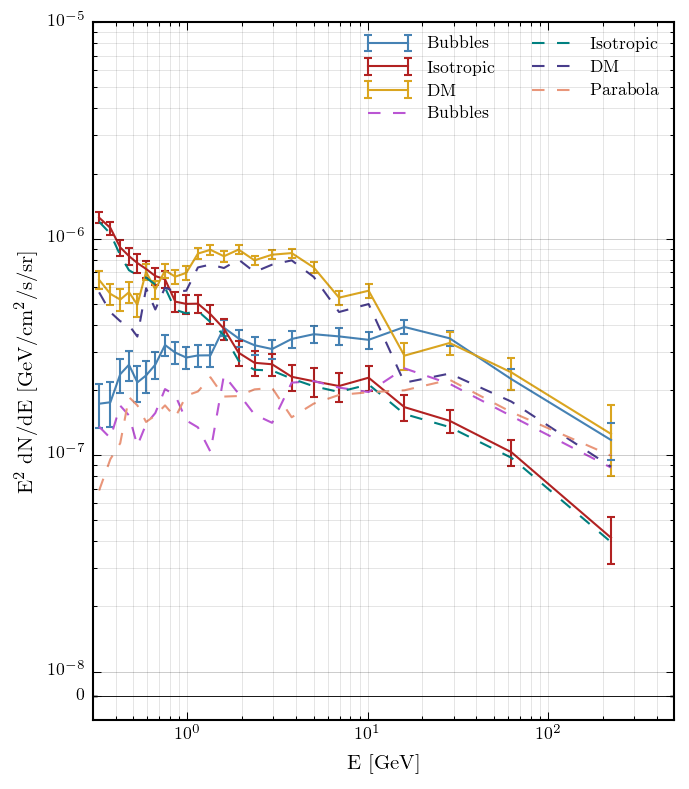

In [23]:
import Template
import Tools, healpy
reload(Tools)


#print np.array(A.m.matrix()).shape

#print A.templateList['DM'].valueError/A.templateList['DM'].value


plt.figure(figsize=(5,6))
def PlotComponent(A, name,ls='-'):
    E, flux, stat = A.GetSpectrum(name)
    #if stat
    
    if ls=='-':
        yerr = E**2*stat.T/1e3
    else:
        yerr=None
    
    if name is 'Data':
        plt.errorbar(E/1e3,E**2*flux/1e3,E**2*stat.T/1e3, label=name.replace('_','+'),
                     capthick=1, capsize=2, ls='-',c='k')    
    else:
        plt.errorbar(E/1e3,E**2*flux/1e3, yerr=yerr, label=name.replace('_','+'),capthick=1, capsize=2, ls=ls )
        
        
        
    
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    plt.xlabel(r'$\rm{E\ [GeV]}$')
    plt.grid(which='both', alpha=.1, linestyle='-')
    
#PlotComponent(A,'Data')    
#PlotComponent(A,'PSC')
#PlotComponent(A,'Pi0_Brems')
#PlotComponent('Brems')
#PlotComponent(A,'ICS')
PlotComponent(A,'Bubbles')
PlotComponent(A,'Isotropic')
PlotComponent(A,'DM')
#PlotComponent(A,'Parabola')
#PlotComponent(A2,'DM')

#PlotComponent(A2,'Pi0_Brems',ls='--')
#PlotComponent(A2,'ICS',ls='--')
PlotComponent(A2,'Bubbles',ls='--')
PlotComponent(A2,'Isotropic',ls='--')
PlotComponent(A2,'DM',ls='--')
PlotComponent(A2,'Parabola',ls='--')


# print np.sum(A.loglike)
# print np.sum(A2.loglike)

linthresh=1e-8
plt.yscale('symlog', linthreshy=linthresh, subsy=np.arange(0,10),linscaley=0.1)
plt.ylim(-1e-8,1e-5)

plt.legend(frameon=False, fontsize=8,ncol=2, handlelength=3)
#plt.ylim(1e-8,4e-4)
plt.xlim(.3,500)

#A.SaveSpectra('./mod_c/spec_mod_s_42_P8_GC_free_brems.pickle') # 3FGL with ext XCO fitted 
#A.SaveSpectra('./mod_c/spec_mod_s_44_P8_GC_free_brems.pickle') # 3FGL with ext XCO fitted 
#A.SaveSpectra('./mod_c/spec_mod_s_46_P8_GC.pickle') # 3FGL with ext XCO fitted 


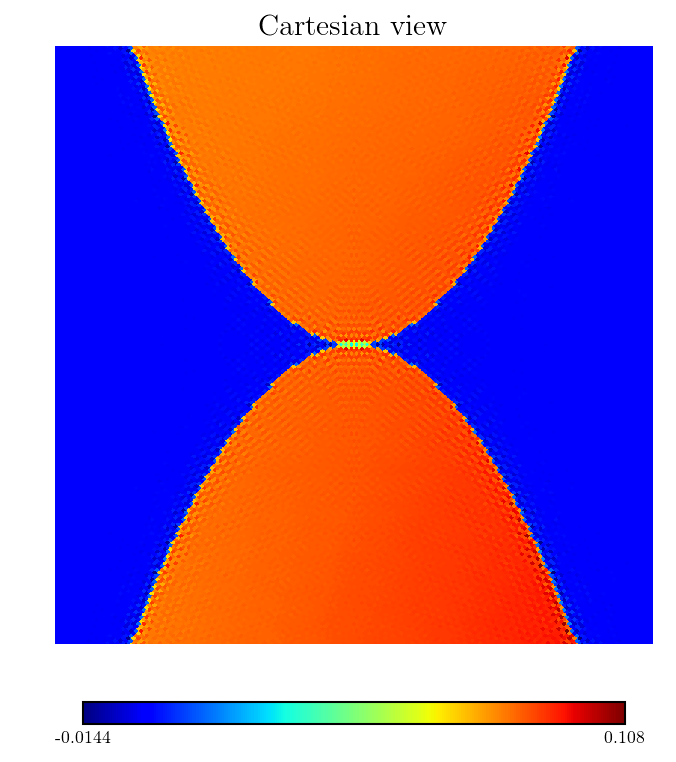

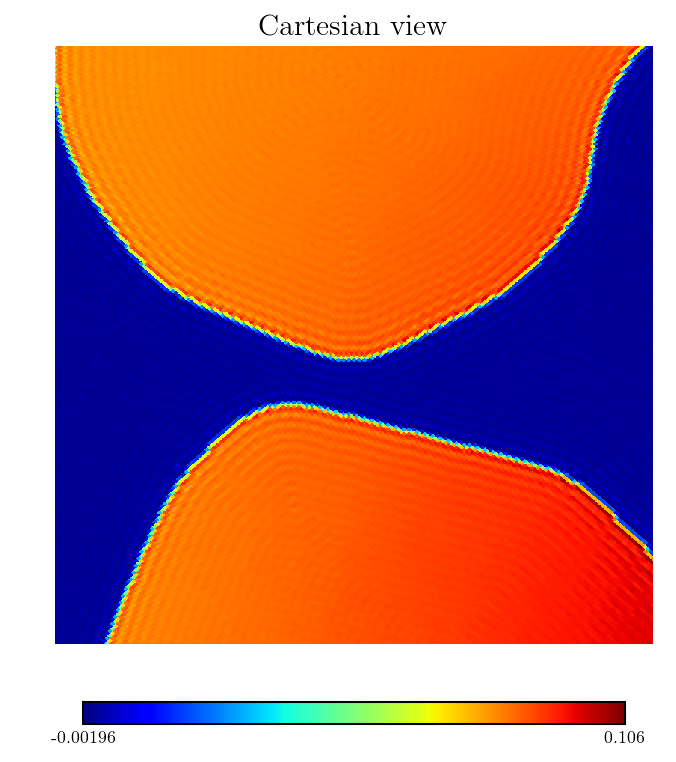

In [19]:
import healpy
healpy.cartview(A.templateList['Parabola'].healpixCube[20], latra=[-20,20], lonra=[-20,20])
healpy.cartview(A.templateList['Bubbles'].healpixCube[20], latra=[-20,20], lonra=[-20,20])